<a href="https://colab.research.google.com/github/zacharylazzara/tent-detection/blob/main/unet_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setting environment variables

%env S_PATH=/content/sarpol-zahab-tents/data
%env U_PATH=/content/unet
%env D_PATH=/content/unet/data/tent
%env T_PATH=/content/unet/data/tent/train
%env I_PATH=/content/unet/data/tent/train/image
%env L_PATH=/content/unet/data/tent/train/label
%env A_PATH=/content/unet/data/tent/train/aug
%env V_PATH=/content/unet/data/tent/test
%env N_PATH=/content/unet/data/tent/npydata

env: S_PATH=/content/sarpol-zahab-tents/data
env: U_PATH=/content/unet
env: D_PATH=/content/unet/data/tent
env: T_PATH=/content/unet/data/tent/train
env: I_PATH=/content/unet/data/tent/train/image
env: L_PATH=/content/unet/data/tent/train/label
env: A_PATH=/content/unet/data/tent/train/aug
env: V_PATH=/content/unet/data/tent/test
env: N_PATH=/content/unet/data/tent/npydata


In [2]:
# Preparing directories
# TODO: make sure we pull the specific version of unet and the dataset so that if they change in the future we don't need to update the code

%%bash
if [ ! -d $S_PATH ]; then
 git clone https://github.com/tofighi/sarpol-zahab-tents.git
 git clone https://github.com/zhixuhao/unet.git
 
 rm -r $U_PATH/data
 rm -r $U_PATH/img
 
 mkdir -p $I_PATH
 mkdir -p $L_PATH
 mkdir -p $A_PATH
 
 mkdir -p $V_PATH
 mkdir -p $N_PATH

 rm -r /content/sample_data
fi

Cloning into 'sarpol-zahab-tents'...
Cloning into 'unet'...


In [3]:
# Image Processing

# https://medium.com/coinmonks/learn-how-to-train-u-net-on-your-dataset-8e3f89fbd623




from os import environ
from PIL import Image
from glob import glob
import numpy as np

s_path = environ.get("S_PATH")
t_path = environ.get("T_PATH")
v_path = environ.get("V_PATH")

# TODO: make sure these lists are in the same order
#imgs = list(map(Image.open, sorted(glob("{}/images/*".format(s_path)))))
#lbls = list(map(Image.open, sorted(glob("{}/labels/*".format(s_path)))))


#imgs = np.array([np.asarray(Image.open(path).convert('RGB')) for path in sorted(glob("{}/images/*".format(v_path)))])
#lbls = np.array([np.asarray(Image.open(path).convert('RGB')) for path in sorted(glob("{}/labels/*".format(v_path)))])

imgs = np.array([np.asarray(Image.open(path).convert('RGB').resize((256, 256))) for path in sorted(glob("{}/images/*".format(s_path)))])
lbls = np.array([np.asarray(Image.open(path).convert('RGB').resize((256, 256))) for path in sorted(glob("{}/labels/*".format(s_path)))])



print(imgs.shape)
print(lbls.shape)


if imgs.shape[0] == lbls.shape[0]:
  # l_i = 0
  # i_i = 0

  # for lbl in lbls:
  #   # TODO: check that file names are the same
  #   # Any image modifications (cropping, etc) should be done here, before img.save()

  #   if l_i < lbls.shape[0]/2 and np.sum(lbl==255) > 0: # TODO: come up with a better way to divide the dataset
  #     Image.fromarray(lbl).save("{}/{}_actual.png".format(v_path, l_i))
  #   else:
  #     Image.fromarray(lbl).save("{}/label/{}.tif".format(t_path, l_i))
  #   l_i += 1

  # for img in imgs:
  #   if i < imgs.shape[0]/2: # TODO: come up with a better way to divide the dataset
  #     Image.fromarray(img).save("{}/{}.png".format(v_path, i_i)) # we need to put some data in the test directory
  #   else:
  #     Image.fromarray(img).save("{}/image/{}.tif".format(t_path, i_i))
  #   i_i += 1


  n = lbls.shape[0]
  index = 0 # decouple the image name from the index since unet expects filenames to be a specific way and order it seems

  for i in range(n):
    # TODO: check that file names are the same
    # Any image modifications (cropping, etc) should be done here, before img.save()

    # imgs[i] = imgs[i].convert("RGB").resize((256, 256))
    # lbls[i] = lbls[i].convert("RGB").resize((256, 256))

    if i < n/2 and np.sum(lbls[i]==255) > 0: # TODO: come up with a better way to divide the dataset
      Image.fromarray(imgs[i]).save("{}/{}.png".format(v_path, index)) # we need to put some data in the test directory
      Image.fromarray(lbls[i]).save("{}/{}_actual.png".format(v_path, index))
      index += 1
    else:
      Image.fromarray(imgs[i]).save("{}/image/{}.tif".format(t_path, i))
      Image.fromarray(lbls[i]).save("{}/label/{}.tif".format(t_path, i))
    




    #if np.sum(lbls[i] == 255) > 0: # For now, we're only gonna work with labels that have tents


(256, 256, 256, 3)
(256, 256, 256, 3)


In [4]:
# Modifying unet
%%bash
sed -i '8s/.*/from tensorflow.keras.optimizers import Adam/' unet/model.py
sed -i '55s/.*/    model = Model(inputs, conv10)/' unet/model.py
sed -i "s/membrane/tent/" unet/main.py


In [5]:
# Running dataPrepare.ipynb
%cd unet/

from data import *

#if you don't want to do data augmentation, set data_gen_args as an empty dict.
#data_gen_args = dict()

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGenerator = trainGenerator(20,'data/tent/train','image','label',data_gen_args,save_to_dir = "data/tent/train/aug")


#you will see 60 transformed images and their masks in data/membrane/train/aug
num_batch = 3
for i,batch in enumerate(myGenerator):
    if(i >= num_batch):
        break


image_arr,mask_arr = geneTrainNpy("data/tent/train/aug/","data/tent/train/aug/")
np.save("data/image_arr.npy",image_arr)
np.save("data/mask_arr.npy",mask_arr)

/content/unet
Found 204 images belonging to 1 classes.
Found 204 images belonging to 1 classes.


In [6]:
# Train Unet (trainUnet.ipynb)

from model import *
from data import *

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'data/tent/train','image','label',data_gen_args,save_to_dir = None)
model = unet()
model_checkpoint = ModelCheckpoint('unet_tent.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=2000,epochs=5,callbacks=[model_checkpoint])

imgs_train,imgs_mask_train = geneTrainNpy("data/tent/train/aug/","data/tent/train/aug/")
model.fit(imgs_train, imgs_mask_train, batch_size=2, epochs=10, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])

testGene = testGenerator("data/tent/test")
model = unet()
model.load_weights("unet_tent.hdf5")
results = model.predict(testGene,30,verbose=1) # I think the 30 is the number of images we're gonna look at?
saveResult("data/tent/test",np.uint8(results)) # might need to remove np.uint8 and put it back to just results, not sure yet

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Found 204 images belonging to 1 classes.
Found 204 images belonging to 1 classes.
1/1 [==============================] - 17s 17s/step - loss: 0.7399 - accuracy: 0.0074

Epoch 00001: loss improved from inf to 0.73994, saving model to unet_tent.hdf5
Epoch 1/10
32/32 [==============================] - 481s 15s/step - loss: 0.6924 - accuracy: 0.9920 - val_loss: 0.6915 - val_accuracy: 0.9996

Epoch 00001: loss improved from 0.73994 to 0.69244, saving model to unet_tent.hdf5
Epoch 2/10
32/32 [==============================] - 489s 15s/step - loss: 0.6907 - accuracy: 0.9994 - val_loss: 0.6899 - val_accuracy: 0.9996

Epoch 00002: loss improved from 0.69244 to 0.69073, saving model to unet_tent.hdf5
Epoch 3/10
32/32 [==============================] - 494s 15s/step - loss: 0.6891 - accuracy: 0.9994 - val_loss: 0.6883 - val_accuracy: 0.9996

Epoch 00003: loss improved from 0.69073 to 0.68914, saving model to unet_tent.hdf5
Epoch 4/10
32/32 [==============================] - 494s 15s/step - loss: 

/content/unet/data.py:124: UserWarning: data/tent/test/0_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
/content/unet/data.py:124: UserWarning: data/tent/test/1_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
/content/unet/data.py:124: UserWarning: data/tent/test/2_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
/content/unet/data.py:124: UserWarning: data/tent/test/3_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
/content/unet/data.py:124: UserWarning: data/tent/test/4_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
/content/unet/data.py:124: UserWarning: data/tent/test/5_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
/content/unet/data.py:124: UserWarning: data/tent/test/6_predict.png is a low cont

label shape: (count, width, height, channels)
a_lbl shape:  (30, 256, 256, 3)
p_lbl shape:  (30, 256, 256, 3)
c_lbl shape:  (60, 256, 256, 3)


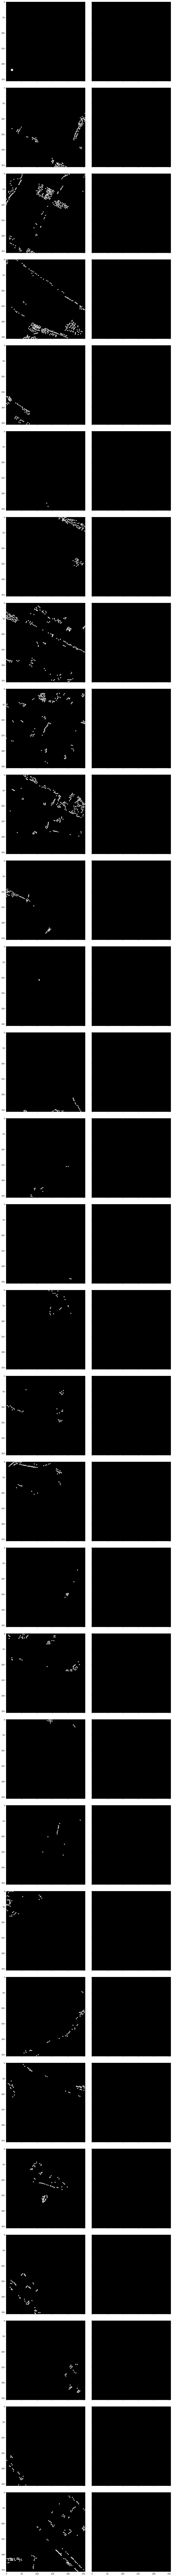

In [7]:
# View Results

from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

v_path = environ.get("V_PATH")

p_lbls = np.array([np.asarray(Image.open(path).convert('RGB')) for path in sorted(glob("{}/*predict.png".format(v_path)))])
a_lbls = np.array([np.asarray(Image.open(path).convert('RGB')) for path in sorted(glob("{}/*actual.png".format(v_path)))][:p_lbls.shape[0]])

print("label shape: (count, width, height, channels)")
print("a_lbl shape: ", a_lbls.shape)
print("p_lbl shape: ", p_lbls.shape)

# If shapes aren't equal this won't work
c_lbls = np.array([img for arr in np.stack((a_lbls, p_lbls), axis=1) for img in arr])

print("c_lbl shape: ", c_lbls.shape)

n = int(c_lbls.shape[0]/2)

fig = plt.figure(figsize=(c_lbls.shape[1], c_lbls.shape[2]))
grid = ImageGrid(fig, 111, nrows_ncols=(n, 2), axes_pad=0.5)

for ax, im in zip(grid, c_lbls):
  ax.imshow(im)

plt.show()